C:\Users\ghadf\AppData\Local\Temp\ipykernel_12984\3620255856.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))
C:\Users\ghadf\AppData\Local\Temp\ipykernel_12984\3620255856.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
C:\Users\ghadf\AppData\Local\Temp\ipykernel_12984\3620255856.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy

      SEASON_ID_x     TEAM_ID TEAM_ABBREVIATION_x           TEAM_NAME  \
26521       12018  1610612766                 CHA   Charlotte Hornets   
26522       12018  1610612738                 BOS      Boston Celtics   
26504       12018  1610612755                 PHI  Philadelphia 76ers   
26505       12018  1610612753                 ORL       Orlando Magic   
26516       12018  1610612752                 NYK     New York Knicks   
...           ...         ...                 ...                 ...   
344         42022  1610612748                 MIA          Miami Heat   
339         42022  1610612748                 MIA          Miami Heat   
340         42022  1610612743                 DEN      Denver Nuggets   
335         42022  1610612743                 DEN      Denver Nuggets   
336         42022  1610612748                 MIA          Miami Heat   

          GAME_ID  GAME_DATE      MATCHUP WL  MIN  PTS  FGM  FGA  FG_PCT  \
26521  0011800008 2018-09-30    CHA @ BOS  L  2

C:\Users\ghadf\AppData\Local\Temp\ipykernel_12984\3620255856.py:191: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = season_data.corr()


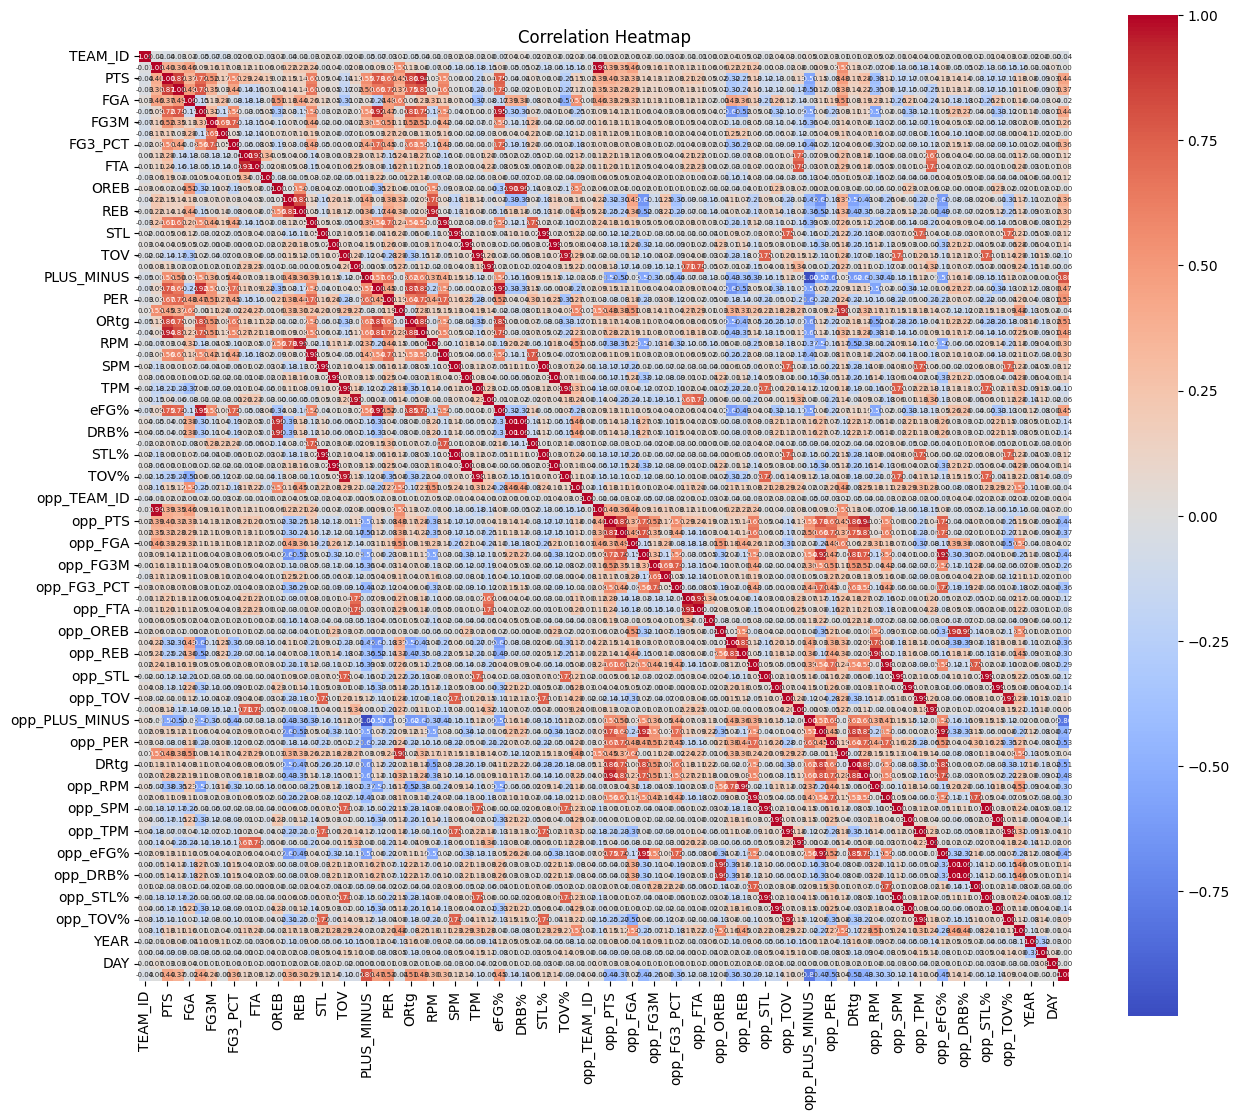

In [32]:
#todos: normalize the stats, add in the teams from 1979 on that are missing from the data,
#change just the non percentage continuous variables in the X dataset
#previous year was released on 8/17, see if in new season data are there then
#look into XGBoost for the gradient boosting regressor

from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

teams = teams.get_teams()
#print(teams)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# List of current NBA team IDs
current_teams = [1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]
#print('base_data = ',data.columns)
#print(data.head())
#stat addons list: PER, TS%, eFG%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP
#adding TS%= PTS / (2 * (FGA + 0.44 * FTA))
data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / MIN
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])/ data['MIN']


#**OFF Rating add
# Calculate offensive and defensive possessions
data['Offensive_Possessions'] = data['FGA'] + 0.44 * data['FTA'] + data['TOV'] - data['OREB']
#data['Defensive_Possessions'] = data['Opponent_FGA'] + 0.44 * data['Opponent_FTA'] + data['Opponent_TOV'] - data['Opponent_OREB']

# Calculate Offensive Rating and Defensive Rating
data['ORtg'] = (data['PTS'] / data['Offensive_Possessions']) * 100
#data['DRtg'] = (data['Points_Allowed'] / data['Defensive_Possessions']) * 100

#add points per minute  
data['PPM'] = data['PTS'] / data['MIN']

#adding rebounds per minute
data['RPM'] = data['REB'] / data['MIN']

#adding assists per minute
data['APM'] = data['AST'] / data['MIN']

#adding steals per minute
data['SPM'] = data['STL'] / data['MIN']

#adding blocks per minute
data['BPM'] = data['BLK'] / data['MIN']

#adding turnovers per minute
data['TPM'] = data['TOV'] / data['MIN']

#adding fouls per minute
data['FPM'] = data['PF'] / data['MIN']

#adding eFG%
data['eFG%'] = (data['FGM'] + 0.5 * data['FG3M']) / data['FGA']

#adding ORB%
data['ORB%'] = data['OREB'] / (data['OREB'] + data['DREB'])

#adding DRB%
data['DRB%'] = data['OREB'] / (data['OREB'] + data['DREB'])

#adding TRB% ***not sure if this is correct, it's not working
#data['TRB%'] = (data['OREB'] + data['DREB']) / data['REB']

#adding AST%
data['AST%'] = data['AST'] / data['FGM']

#adding STL%
data['STL%'] = data['STL'] / data['MIN']

#adding BLK%
data['BLK%'] = data['BLK'] / data['MIN']

#adding TOV%
data['TOV%'] = data['TOV'] / (data['FGA'] + 0.44 * data['FTA'] + data['TOV'])

#adding USG%
data['USG%'] = (data['FGA'] + 0.44 * data['FTA'] + data['TOV']) / data['MIN']

#adding points per minute
data['PPM'] = data['PTS'] / data['MIN']

#adding OWS
#adding DWS
#adding WS
3#adding WS/48
#adding OBPM
#adding DBPM
#adding BPM
#adding VORP
#adding O/D Rating
#adding O/D Win Shares
#adding O/D Win Shares
#adding O/D WS/48
#adding O/D BPM
#adding O/D BPM
#adding O/D VORP
#adding O/D VORP

#**Adding Defensive Stats
#filter for only game_id = 1522300067  <example of a duplicate where there was no data in the WL column so they doubled the record>
data = data.dropna()
data = data.drop_duplicates(subset=['GAME_ID', 'TEAM_ABBREVIATION'], keep='first')
#data = data[data['GAME_ID'] == "1522300067"]
#print(data.head())

# Decide which columns you don't want to rename
exclude_columns = ['SEASON_ID', 'GAME_ID', 'TEAM_ABBREVIATION']

# Rename columns to add 'opp_' prefix, excluding specific columns
rename_dict = {col: 'opp_' + col for col in data.columns if col not in exclude_columns}
df_opponent = data.rename(columns=rename_dict)

# Merge the original DataFrame with the opponents' stats using GAME_ID
data = pd.merge(data, df_opponent, on='GAME_ID')

# Filter out rows where TEAM_ID matches opp_TEAM_ID, because we want stats of different teams in the same row
data = data[data['TEAM_ID'] != data['opp_TEAM_ID']]

#rename the offensive possessions column to defensive possessions
data = data.rename(columns={'opp_offensive_possessions': 'defensive_possessions'})
data = data.rename(columns={'opp_ORtg': 'DRtg'})

# To display the entire DataFrame without truncating

#print(data.head())
#print(data.columns)
#print(data.shape)
# Export to CSV
#data.to_csv('exported_data.csv', index=False)

#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Drop Missing values
# Drop rows with missing values
data_encoded = data.dropna()

# Filter the data to include only selected columns
#data_encoded_selected = data_encoded.iloc[:, :40]

# Check if the 2022-2023 NBA season is in the data. previous year was released on 8/17, see if in data then
#has_23_24_schedule = any(data_encoded_selected['SEASON_ID'] == 42023)
#print('has_23_24_schedule = ',has_23_24_schedule)


# Filter the data for the 2022-2023 NBA season - changing to 1979-2023
#could also use season_id = 42022
start_date = pd.to_datetime('1979-10-01')
end_date = pd.to_datetime('2023-06-30')
season_data = data_encoded[(data_encoded['GAME_DATE'] >= start_date) & (data_encoded['GAME_DATE'] <= end_date)].copy()

#sort season_data by game_id and game_date
#proof that the dataset is team stats per game and not combined team stats per game
season_data = season_data.sort_values(by=['GAME_DATE','GAME_ID'])


# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
print(season_data)


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
season_data = season_data[[col for col in season_data.columns if col != 'WL_encoded'] + ['WL_encoded']]

# Create a correlation matrix for the selected columns
correlation_matrix = season_data.corr()

# Plot the heatmap
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

#In this code, we reorder the columns of season_data so that the target variable 'WL_encoded' is at the end. 
# Then, we calculate the correlation matrix using season_data.corr() and plot the heatmap using sns.heatmap(). 
# The heatmap will show the correlation values between different variables, with positive correlations in warmer colors and negative 
# correlations in cooler colors. The annot=True parameter shows the actual correlation values on the heatmap, and fmt='.2f' formats 
# the numbers to two decimal places. The cmap='coolwarm' parameter sets the color scheme for the heatmap.